### Download data files from the CATH database and set up the environment 
The data we want to use for this project is the latest release of the CATH classification data, namely version s40_v4_3_nonredundant.
- 'domain_list_nonredundant_s40_v4_3.list' contains the list of cath ids for each protein domain.
- 'sequences_nonredundant_s40_v4_3.list' contains the sequences of protein domains.
- 'cath_domain_list.list' has the information about each protein domain incl. class, architecture, superfamily labels and more.
- 'pdb_files.tgz' has the pdb files representing the 3D secondary structure of each protein domain

In [ ]:
# curl http://download.cathdb.info/cath/releases/all-releases/v4_3_0/non-redundant-data-sets/cath-dataset-nonredundant-S40-v4_3_0.list --output domain_list_nonredundant_s40_v4_3.list
#!curl http://download.cathdb.info/cath/releases/all-releases/v4_3_0/non-redundant-data-sets/cath-dataset-nonredundant-S40-v4_3_0.fa --output sequences_nonredundant_s40_v4_3.fa
#!curl http://download.cathdb.info/cath/releases/all-releases/v4_3_0/cath-classification-data/cath-domain-list-v4_3_0.txt --output cath_domain_list.list
#!curl http://download.cathdb.info/cath/releases/all-releases/v4_3_0/non-redundant-data-sets/cath-dataset-nonredundant-S40-v4_3_0.pdb.tgz --output pdb_files.tgz
#!tar -xvzf pdb_files.tgz
#!pip install transformers[torch] evaluate datasets requests pandas scikit-learn peft bitsandbytes matplotlib sentencepiece biopython py3dmol accelerate deepspeed
#!apt install git-lfs
#!pip install wandb
#!wandb login

### Prepare and explore the relevant data with its labels

In [235]:
import pandas as pd

domain_list_nonredundant = pd.read_csv(
    "./domain_list_nonredundant_s40_v4_3.list", header=None, delimiter=r"\s+"
)
domain_list_nonredundant.columns = ["domain_id"]

In [236]:
def read_fasta_to_df(file_path):
    """
    Reads a FASTA file and returns a DataFrame with columns for 'Full ID', 'ID', and 'Sequence'.

    Parameters:
    file_path (str): Path to the FASTA file.

    Returns:
    pd.DataFrame: DataFrame with the FASTA sequences.
    """
    with open(file_path, "r") as file:
        lines = file.readlines()

    data = []
    current_full_id = None
    current_id = None
    current_seq = []

    for line in lines:
        line = line.strip()
        if line.startswith(">"):
            if current_full_id is not None:
                data.append([current_full_id, current_id, "".join(current_seq)])
            current_full_id = line[1:]  # Remove the '>'
            current_id = current_full_id.split("|")[-1].split("/")[
                0
            ]  # Extract the ID part
            current_seq = []
        else:
            current_seq.append(line)

    # Append the last sequence
    if current_full_id is not None:
        data.append([current_full_id, current_id, "".join(current_seq)])

    df = pd.DataFrame(data, columns=["Full ID", "domain_id", "sequences"])
    return df


# Example usage
file_path = "./sequences_nonredundant_s40_v4_3.fa"
sequences = read_fasta_to_df(file_path)

In [237]:
domain_ids = domain_list_nonredundant[
    "domain_id"
].tolist()  # list of relevant domain ids we want to keep

In [238]:
data = pd.read_csv(
    "./cath_domain_list.list",
    sep="\s+",
    header=None,
    usecols=[0, 1, 2, 3, 4, 11],
    comment="#",
)
data.columns = ["domain_id", "cls", "arch", "tplgy", "superfamily", "resolution"]

data

,domain_id,cls,arch,tplgy,superfamily,resolution
0,1oaiA00,1,10,8,10,1.00
1,1go5A00,1,10,8,10,999.00
2,3frhA01,1,10,8,10,1.20
3,3friA01,1,10,8,10,1.80
4,3b89A01,1,10,8,10,2.60
...,...,...,...,...,...,...
500233,4aybQ00,6,20,450,10,3.20
500234,3hkzY00,6,20,450,10,3.40
500235,3hkzZ00,6,20,450,10,3.40
500236,3zbeA00,6,20,450,20,999.00


In [239]:
data = data[data["domain_id"].isin(domain_ids)]
data = data.reset_index(drop=True)
data = data.dropna()  # drop nan rows

In [240]:
# Group by class and architecture and select groups with more than 700 rows
data = data.groupby(["cls", "arch"]).filter(lambda x: len(x) > 700)

data.groupby(["cls", "arch"]).size().reset_index(name="counts")

,cls,arch,counts
0,1,10,4520
1,1,20,2224
2,2,30,975
3,2,40,1386
4,2,60,2967
5,3,10,1315
6,3,20,1103
7,3,30,4815
8,3,40,7073
9,3,90,1529


In [241]:
architecture_names = {
    (1, 10): "Mainly Alpha: Orthogonal Bundle",
    (1, 20): "Mainly Alpha: Up-down Bundle",
    (2, 30): "Mainly Beta: Roll",
    (2, 40): "Mainly Beta: Beta Barrel",
    (2, 60): "Mainly Beta: Sandwich",
    (3, 10): "Alpha Beta: Roll",
    (3, 20): "Alpha Beta: Alpha-Beta Barrel",
    (3, 30): "Alpha Beta: 2-Layer Sandwich",
    (3, 40): "Alpha Beta: 3-Layer(aba) Sandwich",
    (3, 90): "Alpha Beta: Alpha-Beta Complex",
}  # (class, architecture) are the existing labels

sorted_keys = sorted(architecture_names.keys())
label_index_mapping = {key: index for index, key in enumerate(sorted_keys)}

data["label"] = data.apply(
    lambda row: label_index_mapping[(row["cls"], row["arch"])], axis=1
)
data

,domain_id,cls,arch,tplgy,superfamily,resolution,label
0,1oaiA00,1,10,8,10,1.00,0
1,3b89A01,1,10,8,10,2.60,0
2,4heoA00,1,10,8,10,1.65,0
3,1oksA00,1,10,8,10,1.80,0
4,4wp2A00,1,10,8,10,1.70,0
...,...,...,...,...,...,...,...
30768,3fefA00,3,90,1820,10,2.20,9
30769,1ej6B00,3,90,1830,10,3.60,9
30770,1m1cA00,3,90,1840,10,3.50,9
30771,1mukA02,3,90,1850,10,2.50,9


In [242]:
data = pd.merge(
    data,
    sequences,
    on="domain_id",
)
data = data[["domain_id", "superfamily", "label", "sequences", "resolution"]]
data

,domain_id,superfamily,label,sequences,resolution
0,1oaiA00,10,0,PTLSPEQQEMLQAFSTQSGMNLEWSQKCLQDNNWDYTRSAQAFTHL...,1.00
1,3b89A01,10,0,SLNINDALTSILASKKYRALCPDTVRRILTEEWGRHKSPKQTVEAA...,2.60
2,4heoA00,10,0,XVADDASKDVVRTXIRTHIKDRELRSELXDYLNRAETDEEVQEVAN...,1.65
3,1oksA00,10,0,XASRSVIRSIIKSSRLEEDRKRYLXTLLDDIKGANDLAKFHQXLVK...,1.80
4,4wp2A00,10,0,SNAATKAQLIAEVSRRTGMNVEYSQMXLTGAANWNLELALQSFEQQ...,1.70
...,...,...,...,...,...
27902,3fefA00,10,9,XSLDQIKIAYIGGGSQGWARSLXSDLSIDERXSGTVALYDLDFEAA...,2.20
27903,1ej6B00,10,9,NKKTAQLLHADTPRLVTWDAGLCTSFKIVPIVPAQVPQDVLAYTFF...,3.60
27904,1m1cA00,10,9,MLRFVTKNSQDKSSDLFSICSDRGTFVAHNRVRTDFKFDNLVFNRV...,3.50
27905,1mukA02,10,9,PTETVLQEYTQSPEIKVPIPQKDWTGPIGEIRILKDTTSSIARYLY...,2.50


In [243]:
data.groupby(["label"]).size().reset_index(name="counts")

,label,counts
0,0,4520
1,1,2224
2,2,975
3,3,1386
4,4,2967
5,5,1315
6,6,1103
7,7,4815
8,8,7073
9,9,1529


In [244]:
# keep 975 examples per label to create a balanced dataset after keeping the ones with highest resolution (high quality experiments as possible)
data = (
    data.groupby(["label"])
    .apply(lambda x: x.nlargest(800, "resolution"))
    .reset_index(drop=True)
)

data.groupby(["label"]).size().reset_index(name="counts")

/tmp/ipykernel_2217/1407899608.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['label']).apply(lambda x: x.nlargest(800, 'resolution')).reset_index(drop=True)


,label,counts
0,0,800
1,1,800
2,2,800
3,3,800
4,4,800
5,5,800
6,6,800
7,7,800
8,8,800
9,9,800


In [245]:
# Stratified GroupKFold as we need to ensure that the distribution of classes in the training and validation sets are as identical as possible
# We also need to ensure that the proteins belonging to one superfamily should be either in the training or in the validation set as we don't want to have some data leakage

from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=658)

df = data.copy()

# Perform the split
for train_idx, val_idx in sgkf.split(
    df["sequences"], df["label"], groups=df["superfamily"]
):
    train_df = df.iloc[train_idx][["sequences", "label", "superfamily", "domain_id"]]
    val_df = df.iloc[val_idx][["sequences", "label", "superfamily", "domain_id"]]
    break  # We only need the first split for train/validation


# Verify no intersection
train_superfamilies = set(train_df["superfamily"])
val_superfamilies = set(val_df["superfamily"])
print(
    "\nIntersection of superfamilies:",
    train_superfamilies.intersection(val_superfamilies),
)


Intersection of superfamilies: set()


In [246]:
train_sequences = train_df["sequences"].tolist()
test_sequences = val_df["sequences"].tolist()
# train_sequences_3d = train_df["seq3d"].tolist()
# test_sequences_3d = val_df["seq3d"].tolist()
train_labels = train_df["label"].tolist()
test_labels = val_df["label"].tolist()

<Axes: >

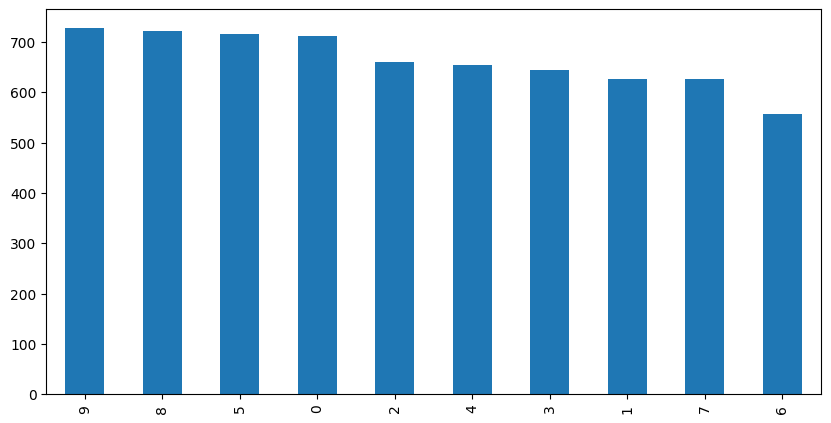

In [247]:
pd.Series(train_labels).value_counts(sort=True, ascending=False).plot(
    kind="bar", backend="matplotlib", figsize=(10, 5)
)

<Axes: >

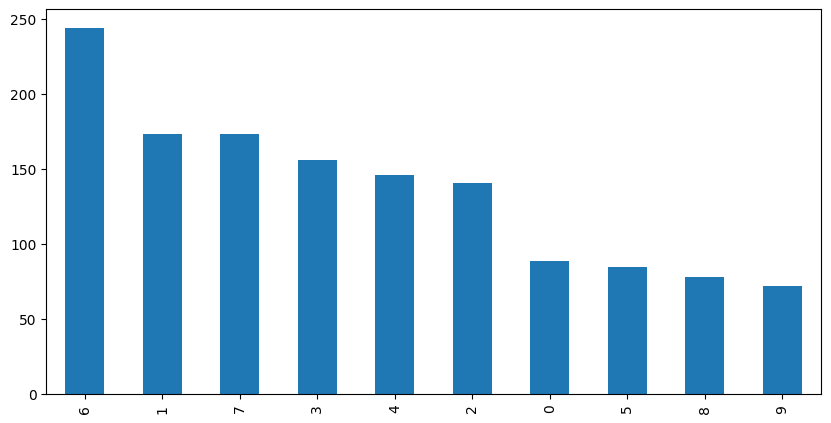

In [248]:
pd.Series(test_labels).value_counts(sort=True, ascending=False).plot(
    kind="bar", backend="matplotlib", figsize=(10, 5)
)

In [249]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

### Data preparation of results from foldseek

In [195]:
import pandas as pd
from Bio import SeqIO
import os

# Change to the desired directory
# os.chdir("/root")
# Verify the change
print(os.listdir("./"))

with open("./queryDB_ss.fasta") as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for seq_record in SeqIO.parse(fasta_file, "fasta"):  # (generator)
        identifiers.append(seq_record.id)
        seqs.append(str(seq_record.seq).lower())

s1 = pd.Series(identifiers, name="ID")
s2 = pd.Series(seqs, name="length")
# Gathering Series into a pandas DataFrame and rename index as ID column
df = pd.DataFrame(dict(domain_id=s1, seq3d=s2)).set_index(["domain_id"])

['onstart.sh', 'ports.log', 'cath_datasets', 'Untitled.ipynb', '.ipynb_checkpoints', 'domain_list_nonredundant_s40_v4_3.list', 'cath_domain_list.list', 'sequences_nonredundant_s40_v4_3.fa', 'train.csv', 'val.csv', 'foldseek', 'queryDB_ss_h', 'queryDB_ss_h.index', 'queryDB_ss_h.dbtype', 'queryDB_ss.fasta']


In [196]:
df

,seq3d
domain_id,
12asA00,dvvvllvllvlllvllvvlccvlqvaeeddddqkdwpfflqadcwl...
132lA00,dadllrvlvllvlppacdvhdhslllsqqlvvpvqaqadkaddpqf...
153lA00,dqdpqhdlvpddfqaadvvpqvvvpdpdtglvslqvllvvlvvlvv...
155cA00,dvqacvvqvvcvvvvaqlewqqdvhggdrhhhvndynlfqqqlaqq...
16pkA02,dlvqllpqafdqeeeeeeaqavvvcvvlcvqcllphqeyeyaylnl...
...,...
6qulU00,ddpvvlvqffdawdddpvqvvccvpqvktktwtappddfvspqvsc...
6r62A00,daqllvvcvvvpaffeeaeeqdfdqpvllvvllppgqayeyeaaph...
6rxnA00,dwkkaqqppgdiddcvvvvnddpvvddqcdadpppghgpvrigtd


In [197]:
df.to_csv(
    "./foldseek_seq3d.csv"
)  # contains all the 3D sequences from the queryDB after running foldseek

In [254]:
train_df = pd.read_csv("./train.csv")
val_df = pd.read_csv("./val.csv")
df_foldseek = pd.read_csv("./foldseek_seq3d.csv")

In [255]:
train_df

,sequences,label,superfamily,domain_id,seq3d
0,MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKIS...,0,50,1vs5M01,dclvddddqfdafqlvsvcvfqwddnvrsvvlvvvqvadrpdtlvn...
1,MSLVVQEQGSFQHILRLLNTNVDGNIKIVYALTTIKGVGRRYSNLV...,0,50,3u5cS01,dddddddpqfdawdddpngifgwpdlqlcrvvvppprdsvnsvvll...
2,MSFVIEKESDFKYIHRILNTNIDGKRITPIALTGIRGIGRRFAYII...,0,50,2xzmM01,dppdddppplfdqwddadpplifhkdwqlcrccvppphhdpvsvvl...
3,EKSRVAILKANLRKSPVAKDVDLEFLAKMTNGFSGADLTEICQRAC...,0,60,1ypwA06,dqvqqlvqlvvlpdcvpddsdddcfvrdpdgnvvsnqlscqvvcqv...
4,DLWVSGNLISPDLDTVLYLFSDQIDRKRWWGIENDTFGTYERXKEL...,0,240,2ffeA02,dddfpnfdddfvlvlvlcvvlvfacvvvsgagnpfaqvvqvvvvvv...
...,...,...,...,...,...
6638,SPKEILNLTSELLQKCSSPAPGPGKEWEEYVQIRTLVEKIRKKQKG...,9,10,3smtA01,dlvvllvllvvllvllpdddvllvslvvsvvsqvvsqvvddfapdd...
6639,FDNNSHDRVKIKLGVSKSDRLYAXKAEVLARAGIPTSSVFALHFTE...,9,10,3smtA02,dvpdpwdkdkdkdaqdppdpplvlqvlcvvlvhhridiaiqtldpv...
6640,SMERRDGLSGLINMGNTCFMSSILQCLIHNPYFIRHSMSQIHSNNC...,9,10,4fk5A02,dvqqqqldffaappdlcqlprqvlvvqlqdplnlvvlvvcpcvvqf...
6641,MTNPSNSNLQALREELCTPGLDQGHLFEGWPETVDECNERQIALLT...,9,10,3ogzA01,dadqvrlvvvvvvccddlnnqvvlqvphdngpvrgddvsvvqsvvq...


In [252]:
train_df = pd.merge(train_df, df_foldseek, on="domain_id")
val_df = pd.merge(val_df, df_foldseek, on="domain_id")

In [253]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)